In [1]:
import cv2
import os
import cv2
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from cv2 import imshow

C:\Users\mahes\anaconda3\envs\tf2.5.0\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print('Connected to a GPU')
  print(gpu_info)

Connected to a GPU
Mon Jul 18 01:59:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.69       Driver Version: 511.69       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     5W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
hImage, wImage = 1024, 1024
nClasses = 1
batch_size = 1
epochs = 10

feature_layers = [128, 64, 32, 16, 14, 12]

In [5]:
def pre_process_data(path):
  colnames=['Img','x','y','w','h','class','ImgW','ImgH']
  
  annotate_data=pd.read_csv(path, names=colnames)
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(annotate_data['class'])
  idx=tokenizer.word_index
  print(idx)
  annotate_data = annotate_data.astype({"x": float,\
                                        "y": float,\
                                        "w": float,\
                                        "h": float})

  #Resize bb according to image
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]*hImage)/annotate_data.iloc[:,7]
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]*hImage)/annotate_data.iloc[:,7]
  
  annotate_data.iloc[:,5]=idx['object']
  annotate_data['label']=annotate_data\
  [['x','y','w','h','class']].to_numpy().tolist()

  #Converting to x,y,w,h
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]+annotate_data.iloc[:,3])/2.0
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]+annotate_data.iloc[:,4])/2.0
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]-annotate_data.iloc[:,1])
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]-annotate_data.iloc[:,2])
  annotate_data['boxes_xywh']=annotate_data\
  [['x','y','w','h','class']].to_numpy().tolist()
  annotate_data = annotate_data.groupby('Img').aggregate(lambda tdf: tdf.tolist())
  return annotate_data

val_path='SKU110K/SKU110K_fixed/annotations/annotations_val.csv'
val_data=pre_process_data(val_path)
path='SKU110K/SKU110K_fixed/annotations/annotations_train.csv'
data=pre_process_data(path)
test_path='SKU110K/SKU110K_fixed/annotations/annotations_test.csv'
test_data=pre_process_data(test_path)

{'object': 1}
{'object': 1}
{'object': 1}


In [6]:
def read_img(img):
  with tf.io.gfile.GFile(img, 'rb') as fp:
    image = fp.read()
  return image

In [7]:
def wrap_bytes(img):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))

def wrap_float(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def convert_tfrecord(images,labels,out_path):
  root='SKU110K/SKU110K_fixed/images'
  with tf.io.TFRecordWriter(out_path) as writer:
    for i in range(len(images)):
      image=os.path.join(root,images[i])
      img_bytes=read_img(image)
      sku={
            'image':wrap_bytes(img_bytes),
            'x':wrap_float(np.array(labels[i])[:,0]),
            'y':wrap_float(np.array(labels[i])[:,1]),
            'w':wrap_float(np.array(labels[i])[:,2]),
            'h':wrap_float(np.array(labels[i])[:,3]),
            'class':wrap_float(np.array(labels[i])[:,4])
      }
      feature=tf.train.Features(feature=sku)
      example=tf.train.Example(features=feature)
      serialized=example.SerializeToString()
      writer.write(serialized)

out_path='Records/val.tfrecords'
convert_tfrecord(val_data.index,val_data['label'],out_path)

out_path='Records/train.tfrecords'
convert_tfrecord(data.index,data['label'],out_path)

out_path='Records/test.tfrecords'
convert_tfrecord(test_data.index,test_data['label'],out_path)

In [8]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

In [9]:
def show_img(img,label):
  img = cv2.imread(img)
  color = (255,0,0)
  img = cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start = tuple((np.array(label[i][:2])).astype('int'))
    end = tuple((np.array(label[i][2:4])).astype('int'))
    cv2.rectangle(img,start,end,color,2)
  imshow(img)

In [10]:
def convert_format(out,format):
  if format == 'x1y1x2y2':
    return tf.stack([out[...,0]-out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]+out[...,3]/2.0]
    ,axis=-1)

  elif format == 'xywh':
    return tf.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]-out[...,1],
    out[...,4]],axis=-1)  ##sending the class also

In [11]:
def convert_scale(matrix,scale):
  if scale == 'abs':
    return tf.stack([matrix[:,0]*wImage,
    matrix[:,1]*hImage,
    matrix[:,2]*wImage,
    matrix[:,3]*hImage],axis=-1)

  elif scale == 'rel':
    return tf.stack([matrix[:,0]/wImage,
    matrix[:,1]/hImage,
    matrix[:,2]/wImage,
    matrix[:,3]/hImage],axis=-1)    

In [12]:
def normalised_ground_truth(matched_boxes,feature_box,return_format):
  matched_boxes = tf.cast(matched_boxes,dtype=tf.float32)
  feature_box = tf.cast(feature_box,dtype=tf.float32)
  if return_format == "encode":
    return tf.stack([(matched_boxes[:,0] - feature_box[:, 0]) / (feature_box[:, 2]),
                   (matched_boxes[:,1] - feature_box[:, 1]) / (feature_box[:, 3]),
        tf.math.log(matched_boxes[:,2] / feature_box[:, 2]),
        tf.math.log(matched_boxes[:,3] / feature_box[:, 3])],
        axis=-1) / [0.1, 0.1, 0.2, 0.2]

  elif return_format == "decode":
    matched_boxes *= [0.1, 0.1, 0.2, 0.2]
    return tf.stack([matched_boxes[:,0] * feature_box[:, 2] + (feature_box[:, 0]),
                    matched_boxes[:,1] * feature_box[:, 3] + (feature_box[:, 1]),
          tf.math.exp(matched_boxes[:,2]) * feature_box[:, 2],
          tf.math.exp(matched_boxes[:,3]) * feature_box[:, 3]],
          axis=-1)

In [13]:
def create_df_box(feature_layers):
#   s_min+(s_max-s_min)/(m-1)*(k-1)
#   s_min = 0.2
#   s_max = 0.9
#   m = 6

#   scale=[]
#   for k in range(2,8):
#     sk = s_min+(s_max-s_min)/(m-1)*(k-1)
#     scale.append(sk)
#   scale.insert(0,s_min)
#   scale.extend([s_max])

  scale =  [0.03, 0.05, 0.08, 0.12, 0.15, 0.25, 0.35]

  feature_boxes=[]
  for feature_layer in feature_layers:
    if (feature_layer == 128 or feature_layer == 14 or feature_layer == 12):
    #   aspect_ratios=[1,2/3,1/2]
      aspect_ratios=[0.333, 0.416, 1.401]

    else:
    #   aspect_ratios=[1,2/3,3/2,1/2,1/3]
      aspect_ratios=[0.416, 0.553, 0.722, 1.401, 3.131]

    w_ar=[]
    h_ar=[]
    for i in aspect_ratios:
      if int(i) == 1:
        w=scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h=scale[feature_layers.index(feature_layer)]/np.sqrt(i)
        w_ar.append(w)
        h_ar.append(h)
        sk_1 = np.sqrt(scale[feature_layers.index(feature_layer)]* 
                     scale[feature_layers.index(feature_layer)+1])
        w = sk_1*np.sqrt(i)
        h = sk_1/np.sqrt(i)      
      else:
        w = scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h = scale[feature_layers.index(feature_layer)]/np.sqrt(i)
      w_ar.append(w)
      h_ar.append(h)
  
    x_axis = np.linspace(0,feature_layer,feature_layer+1)
    y_axis=np.linspace(0,feature_layer,feature_layer+1)
    xx,yy = np.meshgrid(x_axis,y_axis)
    x = [(i+0.5)/(feature_layer) for i in xx[:-1,:-1]]
    y = [(i+0.5)/(feature_layer) for i in yy[:-1,:-1]]

    if (feature_layer == 128 or feature_layer == 14 or feature_layer == 12):
      ndf_box = 4
    else:
      ndf_box = 6
    ndf_boxes = feature_layer*feature_layer*ndf_box
    nbox_coordinates = 4
    feature_box = np.zeros((ndf_boxes,nbox_coordinates))
    x = np.array(x).reshape(feature_layer*feature_layer)
    x = np.repeat(x,ndf_box)
    y = np.array(y).reshape(feature_layer*feature_layer)
    y = np.repeat(y,ndf_box)

    w_ar = np.tile(w_ar,feature_layer*feature_layer)
    h_ar = np.tile(h_ar,feature_layer*feature_layer)
    feature_box[:,0] = x
    feature_box[:,1] = y
    feature_box[:,2] = w_ar
    feature_box[:,3] = h_ar
    feature_boxes.append(feature_box)
  df_box = np.concatenate(feature_boxes,axis=0)
  return df_box

In [14]:
def iou(box1,box2):
  box1 = tf.cast(box1,dtype=tf.float32)
  box2 = tf.cast(box2,dtype=tf.float32)
  
  x1 = tf.math.maximum(box1[:,None,0],box2[:,0])
  y1 = tf.math.maximum(box1[:,None,1],box2[:,1])
  x2 = tf.math.minimum(box1[:,None,2],box2[:,2])
  y2 = tf.math.minimum(box1[:,None,3],box2[:,3])
  
  #Intersection area
  intersectionArea = tf.math.maximum(0.0,x2-x1)*tf.math.maximum(0.0,y2-y1)

  #Union area
  box1Area = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])
  box2Area = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])
  
  unionArea = tf.math.maximum(1e-10,box1Area[:,None]+box2Area-intersectionArea)
  iou = intersectionArea/unionArea
  return tf.clip_by_value(iou,0.0,1.0)

In [15]:
def df_match(labels,iou_matrix):
  max_values = tf.reduce_max(iou_matrix,axis=1)
  max_idx = tf.math.argmax(iou_matrix,axis=1)
  matched = tf.cast(tf.math.greater_equal(max_values,0.5),
                  dtype=tf.float32)
  gt_box = tf.gather(labels,max_idx)
  return gt_box,matched

In [16]:
def pre_process_img(img,feature_box_conv,matched):
  img = cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), interpolation = cv2.INTER_AREA)
  color = (255,0,0)
  matched_idx = np.where(matched)
  for i in (matched_idx):
    for j in i:
      start = feature_box_conv[j,:2]
      end = feature_box_conv[j,2:4]
      start = tuple((start))
      end = tuple((end))
      cv2.rectangle(img,start,end,color,2)
  plt.title('Matched Boxes')
  imshow(img)  

tf.Tensor(921, shape=(), dtype=int64)


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


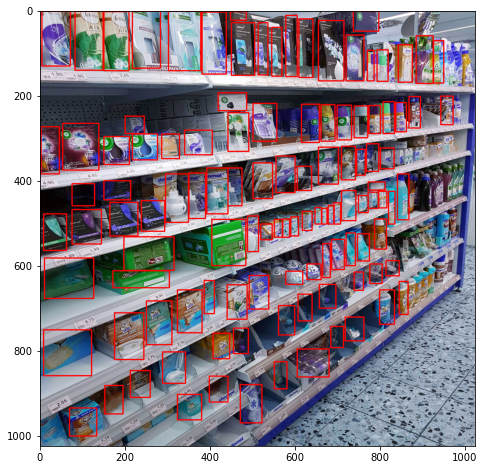

In [17]:
#Matched Boxes
def create_data(data):
  i = 180
  images,labels = data.iloc[i].name,data.iloc[i]['label']
  # labels  x1y1x2y2
  root='SKU110K/SKU110K_fixed/images'

  images=os.path.join(root,images)
      
  #GT boxes creation
  img = images
  label = labels
  show_img(img,label)
  feature_box = create_df_box(feature_layers)
  feature_box = convert_scale(feature_box,'abs')
  feature_box_conv = convert_format(feature_box,'x1y1x2y2')
  iou_matrix = iou(feature_box_conv,np.array(label)[:,:4])
  gt_box,matched = df_match(convert_format(np.array(label),'xywh'),iou_matrix)
  # gt_box xywh
  print(tf.math.count_nonzero(matched))
  pre_process_img(img,convert_format(feature_box,'x1y1x2y2'),matched)
  boxes=gt_box[:,:4]
  classes = gt_box[:,4]
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')  
  normalised_gtbox = normalised_ground_truth(normalised_gtbox,feature_box,'decode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  return df_box

df_box = create_data(data)

In [18]:
#label
feature_box = create_df_box(feature_layers)
feature_box = convert_scale(feature_box,'abs')
feature_box_conv = convert_format(feature_box,'x1y1x2y2')

def main(label):
  iou_matrix = iou(feature_box_conv,label)
  gt_box,matched = df_match(convert_format(label,'xywh'),iou_matrix)
  boxes = gt_box[:,:4]
  classes = gt_box[:,4]
  
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  df_box.set_shape([feature_box.shape[0], 4+nClasses+1])
  return df_box

In [19]:
def convert_back(serialized):  
  feature={
      'image':tf.io.FixedLenFeature([],tf.string),
      'x':tf.io.VarLenFeature(tf.float32),
      'y':tf.io.VarLenFeature(tf.float32),
      'w':tf.io.VarLenFeature(tf.float32),
      'h':tf.io.VarLenFeature(tf.float32),
      'class':tf.io.VarLenFeature(tf.float32)
  }
  parsed_example = tf.io.parse_single_example(serialized=serialized,
                                            features=feature)
  img = tf.io.decode_image(parsed_example['image'],channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img,[hImage, wImage])
  img = tf.cast(img,tf.float32)
  # normalize image 
  img = tf.keras.applications.densenet.preprocess_input(img)

 
  label=tf.stack([tf.sparse.to_dense(parsed_example['x']),
            tf.sparse.to_dense(parsed_example['y']),
            tf.sparse.to_dense(parsed_example['w']),
            tf.sparse.to_dense(parsed_example['h']),
            tf.sparse.to_dense(parsed_example['class']) - 1],axis=-1)
  # label
  df_box = main(label)
  return img, df_box


def data_gen(files):
  autotune = tf.data.experimental.AUTOTUNE
  dataset=tf.data.TFRecordDataset(filenames=files)
  dataset = dataset.map(convert_back, num_parallel_calls=autotune)
  dataset = dataset.apply(tf.data.experimental.ignore_errors())
  dataset = dataset.shuffle(16)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.repeat(epochs)
  dataset = dataset.prefetch(autotune)
  return dataset

test_files='Records/test.tfrecords'
test_dataset = data_gen(test_files)

train_files='Records/train.tfrecords'
train_dataset = data_gen(train_files)

val_files='Records/val.tfrecords'
val_dataset = data_gen(val_files)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [20]:
def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    pos_mask = tf.cast(tf.equal(tf.squeeze(y_true[:, :, 4:5], axis=-1), 0.0),
                       tf.float32)
    num_pos = tf.maximum(
        1.0, tf.cast(tf.math.count_nonzero(pos_mask, axis=-1), tf.float32))
    loc_loss = tf.compat.v1.losses.huber_loss(labels=y_true[:, :, :4],
                                              predictions=y_pred[:, :, :4],
                                              reduction="none")

    loc_loss = tf.reduce_sum(loc_loss, axis=-1)
    loc_loss = tf.where(tf.equal(pos_mask, 1.0), loc_loss, 0.0)
    loc_loss = tf.reduce_sum(loc_loss, axis=-1)
    loc_loss = loc_loss / num_pos

    cce = tf.losses.CategoricalCrossentropy(from_logits=True,
                                            reduction=tf.losses.Reduction.NONE)
    cross_entropy = cce(y_true[:, :, 4:], y_pred[:, :, 4:])

    #neg:pos 3:1
    num_neg = 3.0 * num_pos

    #Negative Mining
    neg_cross_entropy = tf.where(tf.equal(pos_mask, 0.0), cross_entropy, 0.0)
    sorted_dfidx=tf.cast(tf.argsort(neg_cross_entropy,\
                            direction='DESCENDING',axis=-1),tf.int32)
    rank = tf.cast(tf.argsort(sorted_dfidx, axis=-1), tf.int32)
    num_neg = tf.cast(num_neg, dtype=tf.int32)
    neg_loss = tf.where(rank < tf.expand_dims(num_neg, axis=1),
                        neg_cross_entropy, 0.0)

    pos_loss = tf.where(tf.equal(pos_mask, 1.0), cross_entropy, 0.0)
    clas_loss = tf.reduce_sum(pos_loss + neg_loss, axis=-1)
    clas_loss = clas_loss / num_pos
    totalloss = loc_loss + clas_loss
    return totalloss

In [21]:
def conv_layer(filter,kernel_size,
               layer,strides=1,
               padding='same',
               activation='linear',pool=False,
               poolsize=2,poolstride=2,conv=True):
  if conv == True:
      layer = tf.keras.layers.Conv2D(filters=filter,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  activation=activation,
                                  padding=padding,
                                  kernel_initializer='he_normal')(layer)
      layer = tf.keras.layers.BatchNormalization()(layer)
      layer = tf.keras.layers.ReLU()(layer)
  elif pool == True:
    layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize,poolsize),
                                    strides=poolstride,padding='same')(layer)
  return layer

def ssd_model():
  outputs=[]
  densenet_121 = tf.keras.applications.DenseNet121(
                                            input_shape=(hImage, wImage, 3),
                                            include_top=False)
  
  #Feature Layer 1

  layer = densenet_121.get_layer('pool3_relu').output
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 2

  layer = densenet_121.get_layer('pool4_relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)


  #Feature Layer 3 
  
  layer = densenet_121.get_layer('relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4

  layer = conv_layer(128, 1, layer)
  layer = conv_layer(256, 3, layer, strides=2)
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 5 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
                 
  #Feature Layer 6 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
        kernel_size=3,
        padding='same',
        kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  out = tf.keras.layers.Concatenate(axis=1)(outputs)
  model = tf.keras.models.Model(densenet_121.input,out, name='SSD')
  model.summary()
  return model

In [28]:
optimizer = tf.optimizers.Adam(1e-4)

model = ssd_model()

model.compile(optimizer=optimizer,
            loss=total_loss)

callback=tf.keras.callbacks.ModelCheckpoint(
        filepath='ssd_sku/ssd_model_{epoch:02d}.h5',
        monitor='loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        verbose=1)

step_per_epoch = len(data)//batch_size
val_steps = len(val_data)//batch_size

Model: "SSD"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 1030, 1030, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 512, 512, 64) 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________________

In [29]:
model.fit(train_dataset,           
          epochs=epochs,
          validation_data=val_dataset,
          steps_per_epoch=step_per_epoch,
          validation_steps=val_steps,
          callbacks=callback)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[1,512,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node SSD/conv3_block12_concat/concat (defined at <ipython-input-29-e7bd3f80203f>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_75240]

Function call stack:
train_function


In [ ]:
model.load_weights('ssd_model_10.h5')

In [ ]:
def decode(y_pred,df_box):
  y_preds = tf.squeeze(y_pred,axis=0)
  df_box = tf.cast(df_box,dtype=tf.float32)
  boxes = y_preds[:,:4]
  boxes = normalised_ground_truth(boxes,df_box,'decode')
  boxes_x1y1 = convert_format(boxes,'x1y1x2y2')
  y_preds = tf.nn.softmax(y_preds[:,4:])
  cls_idx = tf.argmax(y_preds, axis=-1)
  cls_scores = tf.reduce_max(y_preds, axis=-1)
  #Filter out the backgrund class
  foreground_idx = tf.where(cls_idx != 0)[:, 0]
  print(foreground_idx.shape)

  filtered_boxes = tf.gather(boxes_x1y1, foreground_idx)
  filtered_cls_idx = tf.gather(cls_idx, foreground_idx)
  filtered_cls_scores = tf.gather(cls_scores, foreground_idx)
  filtered_cls_idx = filtered_cls_idx-1

  filtered_boxes_y1x1 = tf.stack([filtered_boxes[:,1],
                                filtered_boxes[:,0],
                                filtered_boxes[:,3],
                                filtered_boxes[:,2]],axis=-1)  
  nms_idx = tf.image.non_max_suppression(filtered_boxes_y1x1,
                                          filtered_cls_scores,
                                          max_output_size=200,
                                          iou_threshold=0.5,
                                          score_threshold=1e-2)
  final_boxes = tf.gather(filtered_boxes, nms_idx)
  final_cls_idx = tf.gather(filtered_cls_idx, nms_idx)
  final_cls_scores = tf.gather(filtered_cls_scores, nms_idx)
  return final_boxes, final_cls_idx, final_cls_scores

In [ ]:
def visualize_detections(image, boxes, classes, scores):
  figsize=(7, 7)
  linewidth=1
  color=[0, 0, 1]
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)
  ax = plt.gca()
  for box, _cls, score in zip(boxes, classes, scores):
      text = '{}: {:.2f}'.format(_cls, score)
      x1, y1, x2, y2 = box
      w, h = x2 - x1, y2 - y1
      patch = plt.Rectangle([x1, y1], w, h, fill=False, 
                            edgecolor=color, linewidth=linewidth)
      ax.add_patch(patch)
      ax.text(x1, y1, text, bbox={'facecolor':color, 'alpha':0.4}, 
              clip_box=ax.clipbox, clip_on=True)

In [ ]:
class_map = {
    1: 'product'
}
for i in range(20, 30):
  image,label = test_data.iloc[i].name,test_data.iloc[i]['label']
  root='SKU110K/SKU110K_fixed/images'

  image_path=os.path.join(root,image)
  
  image = cv2.imread(image_path)
  image = cv2.resize(image, (hImage,wImage))

  image_ = tf.keras.applications.densenet.preprocess_input(image)

  label = main(np.array(label))

  predictions = model(image_[None, ...], training=False)
  feature_box=create_df_box(feature_layers)
  feature_box=convert_scale(feature_box,'abs')
  final_boxes, final_cls_idx, final_cls_scores = decode(predictions,feature_box)
  visualize_detections(image, final_boxes, final_cls_idx, final_cls_scores)